# Thermovision segmentation (altitude & rotation)

## HIT-UAV Dataset

*HIT-UAV provides essential flight data for each image, including flight altitude, camera perspective, date, and daylight intensity. <br>
For each image, the authors have manually annotated object instances with bounding boxes of two types (oriented and standard) <br>to tackle the challenge of significant overlap of object instances in aerial images.*

In [1]:
from pathlib import Path

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import class_weight
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

from src.data import save_alt_rot_images_annotations
from src.models.unet import UNet
from src.utils.process_image import (add_altitude_rotation_channel,
                                     mask_oriented_annotations)
from src.utils.read_file import XMLReader, read_file_to_list
from src.visualizations import mask_rotated_images, plot_rotated_images, plot_model_input_output

ANNOTATIONS_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/Annotations"
DATA_SPLIT_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/ImageSets/Main"
IMAGES_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/JPEGImages"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cpu')

#### Load annotations

In [2]:
xml_reader = XMLReader(ANNOTATIONS_PATH)
annotations = xml_reader.getAnnotation()

# examplary annotation
# annotations['0_100_30_0_03280']

In [3]:
image_names = dict()
for key in ["train", "val", "test"]:
    image_names[key] = read_file_to_list(f"{DATA_SPLIT_PATH}/{key}.txt")

#### Visualize n random images from the training set (images as well as their masks)

In [4]:
n = 10
random_images = np.random.choice(np.arange(len(image_names['train'])), n, replace=False)
random_images = [image_names['train'][i] for i in random_images]
# random_images

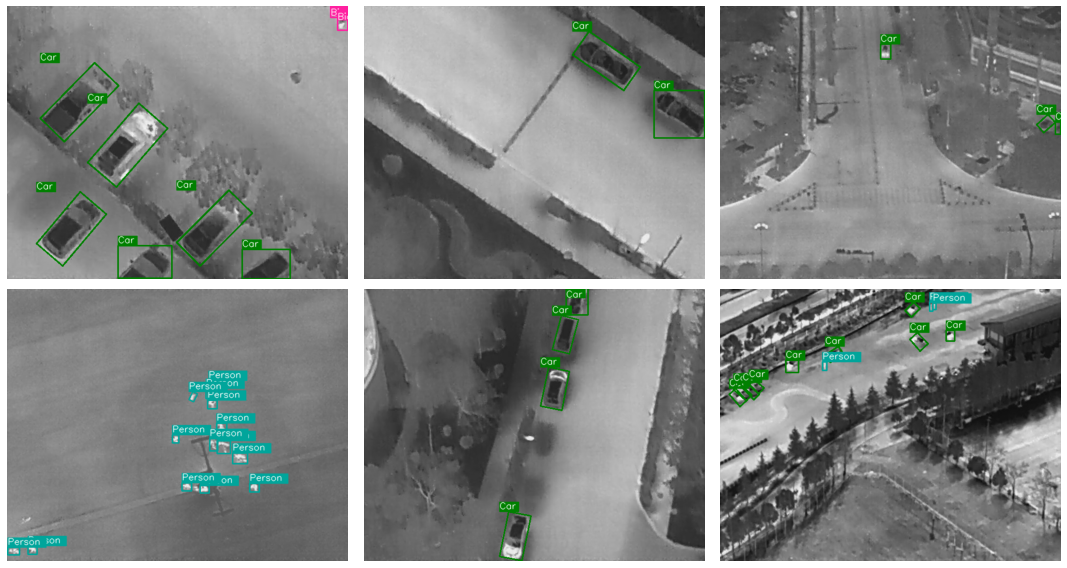

In [5]:
n = 6
rows = 2
cols = 3
figsize = (15, 8)
plot_rotated_images(IMAGES_PATH, 
                    random_images[:n], 
                    annotations, 
                    rows=rows, 
                    cols=cols, 
                    figsize=figsize)

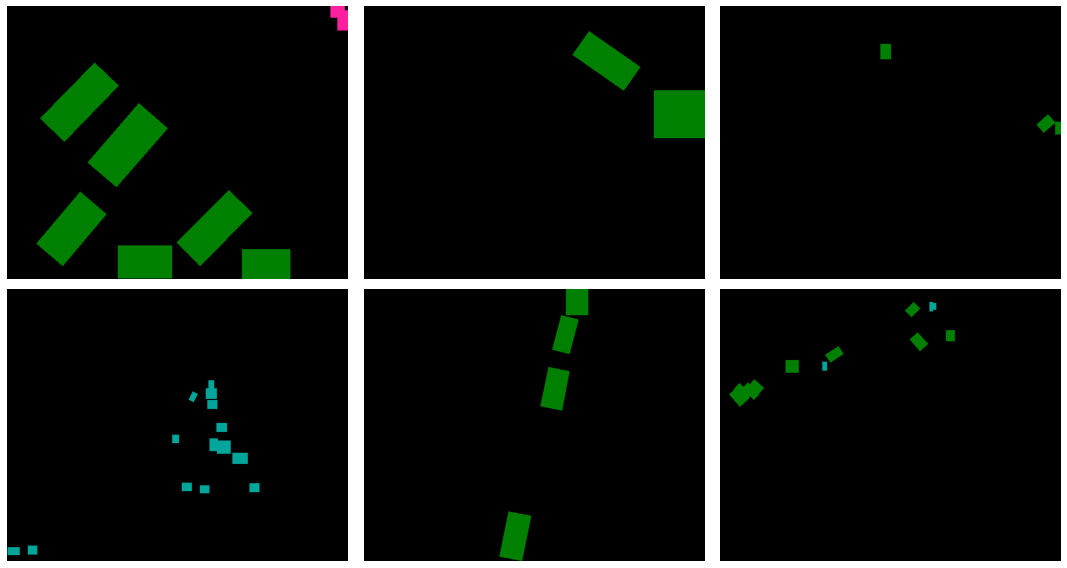

In [6]:
mask_rotated_images(IMAGES_PATH, 
                    random_images[:n], 
                    annotations, 
                    colored_masks=True,
                    rows=rows, 
                    cols=cols, 
                    figsize=figsize)

### Add the altitude information as an additional input channel

Following the idea from the paper: [Elevating point-based object detection in UAVs: A deep learning method with altitude fusion](https://ww2.mini.pw.edu.pl/pprai2024/papers/105.pdf) <br>(presented at the PP RAI 2024 conference), we added the information about the altitude as a separate channel (i.e. using *Method A*):

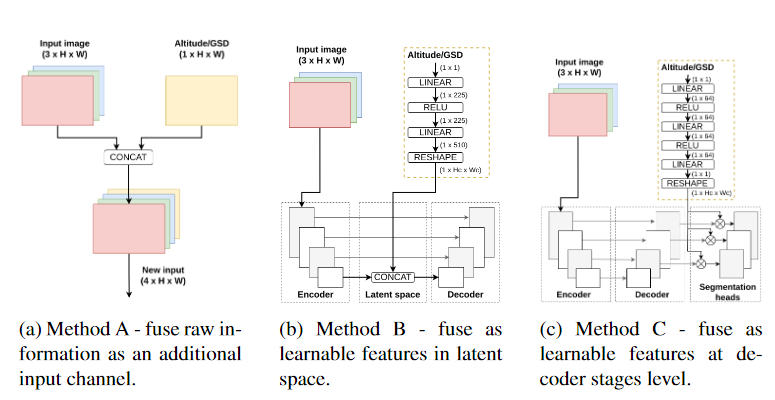

In [7]:
def preprocess_images(
    image_names: list,
    annotations: dict,
    save_dir: Path,
    num_classes: int = 6,
) -> None:
    img_dir = save_dir / "images"
    mask_dir = save_dir / "masks"
    img_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    for i_name in image_names:
        img = cv2.imread(f"{IMAGES_PATH}/{i_name}.jpg")
        img_alt_rot = add_altitude_rotation_channel(img, i_name)
        masked_image = mask_oriented_annotations(img, annotations[i_name])[
            :, :, 0, np.newaxis
        ]  # masks are from range 1-5, the background is 0
        masked_image = torch.nn.functional.one_hot(
            torch.from_numpy(masked_image).squeeze(-1).long(), num_classes=num_classes
        ).numpy()
        cv2.imwrite(str(img_dir / f"{i_name}.jpg"), img_alt_rot)
        np.save(mask_dir / f"{i_name}.npy", masked_image)

    # class_weights = torch.tensor(
    #     class_weight.compute_class_weight(
    #         "balanced", classes=np.unique(all_masks_flat), y=all_masks_flat
    #     )
    # )


In [8]:
train_dir = Path("data/unet/train")
test_dir = Path("data/unet/test")
preprocess_images(image_names["train"], annotations, train_dir)
preprocess_images(image_names["test"], annotations, test_dir)

In [10]:
channels_means = [112.56177, 120.7877, 69.248]
channels_stds = [46.642914, 10.014346, 19.995237]

In [11]:
class UAVDataset(Dataset):
    def __init__(self, image_paths: list[Path], mask_paths: list[Path], mean: list[float], std: list[float]):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                        ])

        self.transform_mask = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(str(self.image_paths[idx]))
        mask = np.load(self.mask_paths[idx], "r").astype(float)

        if self.transform:
            image = self.transform(image)
            mask = self.transform_mask(mask)
        return image, mask

In [12]:
train_images = list(Path("data/unet/train/images").rglob("*.jpg"))
train_masks = list(Path("data/unet/train/masks").rglob("*.npy"))
test_images = list(Path("data/unet/test/images").rglob("*.jpg"))
test_masks = list(Path("data/unet/test/masks").rglob("*.npy"))


train_dataset = UAVDataset(train_images, train_masks, channels_means, channels_stds)
test_dataset = UAVDataset(test_images, test_masks, channels_means, channels_stds)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# len(train_dataset), len(test_dataset)

In [15]:
def train(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int,
    device: str,
    lr: float = 1e-4,
    weight: torch.Tensor = None,
    save_path: str = None,
) -> tuple[nn.Module, list[float], list[float]]:
    
    criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        step_losses = []
        with tqdm(trainloader, unit="batch") as tepoch:
            for input, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                input, target = input.to(device), target.to(device)
                y_pred = model(input)
                loss = criterion(y_pred, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                step_losses.append(loss.cpu().detach().numpy())
        train_losses.append(np.mean(step_losses))
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vdata in enumerate(valloader):
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
                voutputs = model(vinputs)
                vloss = torch.sqrt(criterion(voutputs, vlabels))
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        val_losses.append(avg_vloss.cpu().item())

        if save_path is not None and epoch % 10 == 0:
            torch.save(model.state_dict(), f"{save_path}_{epoch}.pth")

    return model, train_losses, val_losses

In [17]:
# UNet summary
# (original) n1 = 64 - params: 34,5M
# n1 = 32 - params: 8,637,510
# n1 = 16 - params: 2,162,214
# from torchsummary import summary
# summary(model, (3, 512, 640))

In [17]:
# UNet with altitude and rotation added - Method A
number_of_classes = 6 # 5 classes +1 because of the background class
model = UNet(out_ch=number_of_classes, n1=16).to(DEVICE)

model, train_losses, val_losses = train(model, train_loader, test_loader, 
                                        num_epochs=2, 
                                        device=DEVICE,
                                        # weight=class_weights, # TODO: enable for the whole dataset training
                                        )

  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 2/2 [00:25<00:00, 12.75s/batch, loss=1.8]


In [18]:
train_losses, val_losses

([1.8031240551712926, 1.7980118379899297],
 [1.3412013038545454, 1.3393422171342717])

In [ ]:
# # UNet with altitude and rotation added - Method B
# model = UNet(img_size=size, alt_rot_embedding=True)
# output = model(sample_tensor)
# print("Output shape:", output.shape)

### Visualize results

In [25]:
model = UNet(out_ch=6, n1=16)
model.to(DEVICE)
out = model(train_dataset[0][0].unsqueeze(0).to(DEVICE))
print(out.shape)

torch.Size([1, 6, 512, 640])


(512, 640)


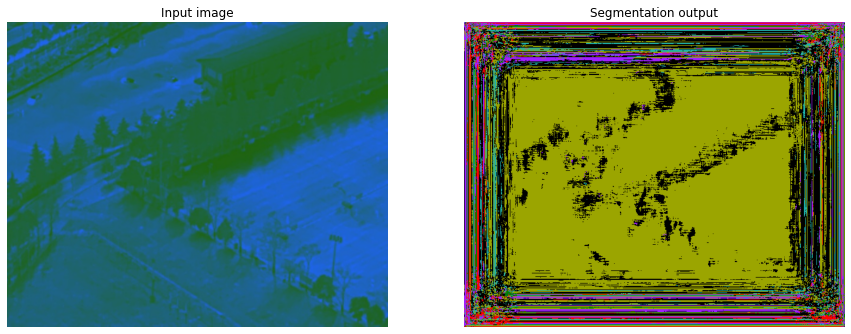

In [26]:
plot_model_input_output(train_images[0], out)

(512, 640)


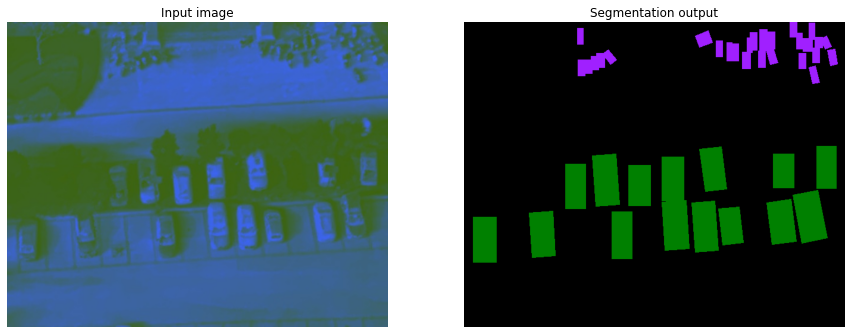

In [27]:
idx = 55
plot_model_input_output(train_images[idx], train_dataset[idx][1].unsqueeze(0))